In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
#sys.path.append( '/home/cactuskid13/miniconda3/pkgs/')
print(sys.path)


['/home/cactuskid13/pyprofiler/pyprofiler/notebooks', '/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python37.zip', '/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7', '/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/lib-dynload', '', '/home/cactuskid13/.local/lib/python3.7/site-packages', '/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages', '/home/cactuskid13/pyham', '/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/IPython/extensions', '/home/cactuskid13/.ipython', '../..']


# Loading libraries and data

+ Precomputed OMA database
+ Go annotation file

In [2]:
#using the profiler. It's easy!
#lets import the profiler, configuration file and some tools for GO analysis to look at our returned results
from pyprofiler.utils import config_utils
import pyprofiler.utils.goatools_utils as goa
import pyprofiler.profiler as profiler
import pandas as pd
import numpy as np

{'dir': {'datadir': '/home/cactuskid13/pyprofiler/pyprofiler/all/all/', 'omadir': '/home/cactuskid13/mntpt/OMA/dec/'}, 'orthoxmltar': '', 'email': 'dmoi@unil.ch'}


In [3]:
#lets also create a go annotation enrichment study object to describe functional enrichment in our profiling results
gaf = goa.buildGAF( '/home/cactuskid13/mntpt/unil_backup/profilingbackup/gaf/oma-go.txt' )
study = goa.return_enrichment_study_obj( gaf , obo = '/home/cactuskid13/mntpt/unil_backup/profilingbackup/gaf/go.obo')

/home/cactuskid13/mntpt/unil_backup/profilingbackup/gaf/go.obo: fmt(1.2) rel(2019-07-01) 47,413 GO Terms

Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
100% 8,270,255 of 8,270,255 population items found in association


In [4]:
#lets load a compiled db containing the OMA root HOGs into a profiler oject 
p = profiler.Profiler(lshforestpath = config_utils.datadir+'newlshforest.pkl' , hashes_h5=config_utils.datadir +'hashes.h5' , mat_path= None, oma = True, tar= None , nsamples = 256)

loading lsh
indexing lsh


Cannot load SequenceSearch. Any future call to seq_search will fail!
Traceback (most recent call last):
  File "../../pyprofiler/pyoma/browser/db.py", line 879, in __init__
    self.seq_idx = self.seq_idx()
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/link.py", line 397, in __call__
    self.extfile = tables.open_file(filename, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 784, in __init__
    self._g_new(filename, mode, **params)
  File "tables/hdf5extension.pyx", line 374, in tables.hdf5extension.File._g_new
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/utils.py", line 157, in check_file_access
    raise IOError("``%s`` does not exist" % (filena

3146
DONE


# Find HOGs for auery genes

Here the gene are ciliary genes:

+ BBS7
+ IFT88
+ MCIDAS


In [56]:
#load the kinetochore data and map it to OMA HOGs
#these are blast results against oma since they had their own adhoc IDs
IDs = [ 'Q8IWZ6' , 'Q13099', 'D6RGH6' ] 
def grabHog(ID):
    try:
        return p.db_obj.entry_by_entry_nr(p.db_obj.id_resolver.resolve(ID))[4].decode()
    except:
        return np.nan
Hogs = dict( zip ( IDs, [ grabHog(i) for i in IDs ]))
print(Hogs)

{'Q8IWZ6': 'HOG:0417627.4b', 'Q13099': 'HOG:0423172.4b', 'D6RGH6': 'HOG:0380029'}


In [57]:
from pyprofiler.utils.hashutils import hogid2fam 
HogDF = pd.DataFrame.from_dict( Hogs , orient = 'index' )
HogDF = HogDF[ HogDF[0].str.len() > 0 ] 
HogDF['fam'] = HogDF[0].map( hogid2fam)

print(HogDF)


                     0     fam
Q8IWZ6  HOG:0417627.4b  417627
Q13099  HOG:0423172.4b  423172
D6RGH6     HOG:0380029  380029


# Get similar gene family and cluster these

In [58]:
res =  { f: p.hog_query( fam_id= f  , k = 15 ) for f in HogDF.fam.unique() if f }
print(res)
HogDF['res'] = HogDF.fam.map(res)


{417627: ['427042', '429254', '421417', '432826', '418813', '431074', '425068', '428094', '417723', '416492', '435213', '426948', '434713', '416133', '417627'], 423172: ['418491', '426003', '425752', '432451', '433313', '417516', '423827', '435974', '426732', '436934', '420598', '423172', '426066', '436267', '428459'], 380029: ['382171', '378536', '380858', '377688', '378480', '378438', '381359', '380029', '380923', '379721', '380023', '377538', '377169', '382060', '378474']}


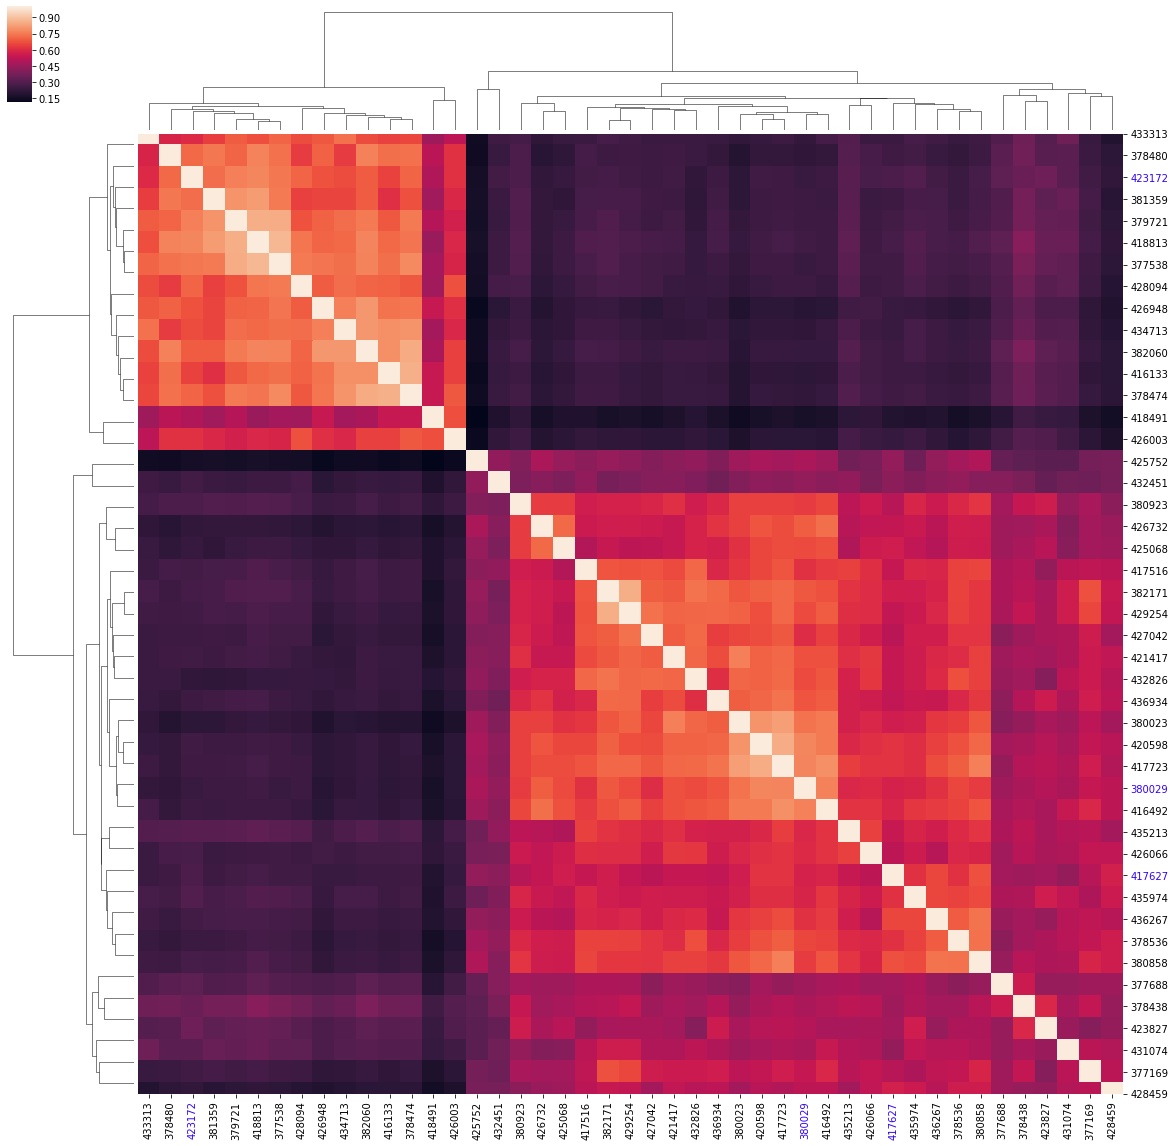

In [54]:
import seaborn as sns
hogs = [ h  for q in res for h in res[q]]

hashes = p.pull_hashes( set(hogs+ list(res.keys()) ) )

jkern = [ [ h1.jaccard(h2) if i<j else 0 for j,h2 in enumerate(hashes.values()) ] for i,h1 in enumerate(hashes.values())]
jkern = np.asarray(jkern)
jkern+=jkern.T

np.fill_diagonal( jkern , 1 )
g = sns.clustermap( jkern , xticklabels=hashes.keys()  , yticklabels=hashes.keys(), figsize = (20,20) )


for tick_label in g.ax_heatmap.axes.get_yticklabels():
    l = tick_label.get_text()
    if int(l) in res:
        c ='#3003fc'
    else:
        c = '#000000'
    tick_label.set_color(c)

for tick_label in g.ax_heatmap.axes.get_xticklabels():
    l = tick_label.get_text()
    if int(l) in res:
        c ='#3003fc'
    else:
        c = '#000000'
    tick_label.set_color(c)


# Cluster analysis

Here, gene ontology enrichment of the whole matrixes.

More precise analyses are available...

In [51]:
for r in res:
    try:
        res[r].remove( str(r) )
    except:
        pass
goares = goa.run_GOEA_onresults( res , p.db_obj, study )
#output the results
goea_results_sig = [r for r in goares[0] if r.p_fdr_bh < 0.1]

compiling hogs
0
done
running GO enrichment study

Run GOEA Gene Ontology Analysis: current study set of 402 IDs ...
100%    295 of    295 study items found in association
 73%    295 of    402 study items found in population(8270255)
Calculating 27,275 uncorrected p-values using fisher_scipy_stats
  27,275 GO terms are associated with 8,270,213 of 8,270,255 population items
     144 GO terms are associated with    295 of    402 study items
  METHOD fdr_bh:
     101 GO terms found significant (< 0.15=alpha) ( 77 enriched +  24 purified): statsmodels fdr_bh
     291 study items associated with significant GO IDs (enriched)
      32 study items associated with significant GO IDs (purified)
done
DONE!


In [52]:
[ print(r ) for r in goea_results_sig]

GO:1905515	BP	e	non-motile cilium assembly    	213/295	1986/8270255	0	7	213	0	ACYPI12185, ACYPI27958, AEDAE02024, AEDAE02083, AILME08093, ANAPL01850, ANODA00324, ANOGA01612, ANOGA07942, APIME05042, APIME05956, ASTMX09806, ASTMX19560, ATTCE10300, ATTCE15193, BOMIM05849, BOMIM10228, BOVIN02791, BOVIN16596, BRAFL14213, BRUMA07719, CAEBE01629, CAEBE07759, CAEBR09011, CAEBR17961, CAEEL09068, CAEEL18454, CAEJA09472, CAEJA17655, CAERE07412, CAERE23930, CALJA13759, CALJA17466, CAMFO00686, CAMFO10046, CANLF06288, CANLF09880, CAPTE19628, CAVPO15619, CAVPO16157, CHILA08242, CHILA20292, CHLSB13571, CHLSB16645, CHOHO09885, CHOHO11337, CIOIN00004, CIOSA11108, CULQU02000, DANRE07304, DANRE41933, DAPPU06811, DAPPU25745, DASNO03782, DASNO03857, DENPD05179, DENPD06262, DIPOR08007, DIPOR12034, DROAN05581, DROBM02720, DROBP03722, DROEL11293, DROER06389, DROEU07653, DROFC12992, DROGR11857, DROKI08932, DROME03784, DROMO09433, DROPE07896, DROPS03130, DRORH12237, DROSI02577, DROTK11044, DROVI03903, DROWI04256

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [9]:
with open( '/home/cactuskid13/mntpt/CATH/cath-names.txt') as cathin:
    cathnames  = { i:{  j : w.strip()   for j,w in enumerate(l.split('    ')) } for i,l in enumerate(cathin)  if l[0] != '#'}
cathdf = pd.DataFrame.from_dict(cathnames, orient= 'index')
mapper = dict(zip(cathdf[0], cathdf[2]))

In [10]:
def hog_arch(fam):
    try:
        return p.db_obj.get_representative_entry_of_hog(fam)
    except:
        return None

def annotate_domain( domainlist ):
    if domainlist is not None:
        return [ mapper[ x[1].decode() ] if x[1].decode() in mapper else None for x in domainlist ]
    else:
        return None

In [42]:
result_domains = { h : { 'rep_entry': hog_arch(h)} for h in set(hogs+ list(res.keys()) )}
print(result_domains)
result_domains = pd.DataFrame.from_dict( result_domains, orient = 'index')
result_domains['domains'] =  result_domains.rep_entry.map( lambda x : x['domains'] if x else None )
result_domains['cath'] = result_domains['domains'].map( annotate_domain) 

{'430933': {'rep_entry': None}, '418406': {'rep_entry': None}, '418125': {'rep_entry': None}, '416408': {'rep_entry': None}, '419941': {'rep_entry': None}, '417054': {'rep_entry': None}, '422173': {'rep_entry': None}, '436531': {'rep_entry': None}, '430564': {'rep_entry': None}, '431168': {'rep_entry': None}, '419114': {'rep_entry': None}, '419051': {'rep_entry': None}, '434262': {'rep_entry': None}, '432831': {'rep_entry': None}, '420844': {'rep_entry': None}, '424084': {'rep_entry': None}, '435343': {'rep_entry': None}, '432279': {'rep_entry': None}, '422341': {'rep_entry': None}, '435988': {'rep_entry': None}, '423904': {'rep_entry': None}, '418320': {'rep_entry': None}, '426759': {'rep_entry': None}, '432256': {'rep_entry': None}, '434974': {'rep_entry': None}, '429379': {'rep_entry': None}, '416736': {'rep_entry': None}, '428160': {'rep_entry': None}, '425553': {'rep_entry': None}, '420443': {'rep_entry': None}, '427489': {'rep_entry': None}, '425548': {'rep_entry': None}, '425464

TypeError: '>' not supported between instances of 'numpy.ndarray' and 'str'

In [45]:
def hog_arch(fam):
    try:
        return p.db_obj.get_representative_entry_of_hog(fam)
    except:
        return None
explicit_profiles['prots'] = explicit_profiles.index.map( hog_arch )
explicit_profiles['domains'] = explicit_profiles.prots.map( lambda x : x['domains'] if x else None )

In [46]:
with open( '/home/cactuskid13/mntpt/CATH/cath-names.txt') as cathin:
    cathnames  = { i:{  j : w.strip()   for j,w in enumerate(l.split('    ')) } for i,l in enumerate(cathin)  if l[0] != '#'}
cathdf = pd.DataFrame.from_dict(cathnames, orient= 'index')
mapper = dict(zip(cathdf[0], cathdf[2]))

In [19]:
#we can enrich for functionality in each cluster
goares = {}

for c in np.unique(clusters):
    sub = profiles.iloc[ np.where( clusters == c ) ]
    #if our cluster contains a query it makes sense to see if we found some interactors related to it
    if len(sub.name.unique()) >1 : 
        print(sub.name.unique())
        queries  = set(sub[ sub.index.map(lambda x : 'HOG' in x )].index )
        #remove the query from search results
        searchfams = [str(hogid2fam(h)) for h in queries ]
        searchres = sub[ sub.index.map(lambda x : 'HOG' not in x )]
        searchres  = searchres[~searchres.index.isin(searchfams)]
        #run a go enrichment study on the cluster
        goares[c] = goa.run_GOEA_onresults( searchres.index.map( hogid2fam ) , p.db_obj, study)
        namestr = ''.join([ n+'_' for n in sub.name if len(n)>0 ])
        #output the results
        goea_results_sig = [r for r in goares[c][0] if r.p_fdr_bh < 0.1]
        study.wr_txt(namestr + "_v2_kinetocluster_enrich.txt", goea_results_sig)
        print(len(goea_results_sig))

['' 'CenpQ' 'CenpW']
compiling hogs
0
10
done
running GO enrichment study

Run GOEA Gene Ontology Analysis: current study set of 315 IDs ...
100%    247 of    247 study items found in association
 78%    247 of    315 study items found in population(8270255)
Calculating 27,275 uncorrected p-values using fisher_scipy_stats
  27,275 GO terms are associated with 8,270,213 of 8,270,255 population items
     160 GO terms are associated with    247 of    315 study items
  METHOD fdr_bh:
     106 GO terms found significant (< 0.15=alpha) ( 91 enriched +  15 purified): statsmodels fdr_bh
     227 study items associated with significant GO IDs (enriched)
      70 study items associated with significant GO IDs (purified)
done
DONE!
    102 GOEA results for   241 study items. WROTE: CenpQ_CenpW__v2_kinetocluster_enrich.txt
102
['' 'CenpC']
compiling hogs
0
done
running GO enrichment study

Run GOEA Gene Ontology Analysis: current study set of 222 IDs ...
100%    188 of    188 study items found in

In [48]:
def donuts_GO( filename , allprots ):
    #this function will read the GO enrichment output and show the proportion of each HOGs annotation for the top 5 GO terms
    #as well as the proportion of each of the top 5 GO terms contributed by each HOG
    #If the HOGs share GO annotations and coevolved but contain non homologous sequences, they are probably involved in the same network
    with open( filename , 'r') as filein:
        vals = np.zeros( (5,40))
        GOterms = []
        pvals = []
        depths = []
        for i,line in enumerate(filein):
            words = line.split(',')
            if i < 5:
                prots = words[1:]
                prots += words[0].split()[-1]
                GOterms.append(words[0].split()[0])
                description= ''.join( [ word + ' ' for word in words[0].split()[0:-1] ] )
                print(description)
                for prot in prots:
                    try:
                        counts[allprots[prot.strip()]]+=1
                    except:
                        pass
                for col,hog in enumerate(counts):
                    vals[i,col] = counts[hog]
            if int(words[0].split()[3].split('/')[0])>0 and float(words[0].split()[2]) <1:
                pvals.append(float(words[0].split()[2]))
        fig, ax = plt.subplots()
        size = 0.3
        cmap = plt.get_cmap("tab20c")
        outer_colors = cmap(np.arange(len(GOterms))*4)
        inner_colors = cmap(np.array([1, 2, 5, 6, 9]))

        ax.pie(vals.sum(axis=1),  labels=GOterms ,radius=1, colors=outer_colors,
               wedgeprops=dict(width=size, edgecolor='w'))
        ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
               wedgeprops=dict(width=size, edgecolor='w'))
        ax.set(aspect="equal", title= 'query w/ '+ hog)

        #### do the inverse
        fig, ax = plt.subplots()
        size = 0.3
        cmap = plt.get_cmap("tab20c")
        inner_colors = cmap(np.arange(len(GOterms))*4)
        outer_colors = cmap(np.array([1, 2, 5, 6, 9]))
        labels = [ c  if counts[c]>50 else ''  for c in counts.keys() ]
        ax.pie(vals.sum(axis=0),  labels=list(counts.keys()) ,radius=1, colors=outer_colors,
               wedgeprops=dict(width=size, edgecolor='w'))
        ax.pie(vals.T.flatten(), radius=1-size, colors=inner_colors,
               wedgeprops=dict(width=size, edgecolor='w'))
        ax.set(aspect="equal", title= 'query w/ '+ hog)
        plt.show()
        fig, ax = plt.subplots()
        size = 0.3
        ax.hist( np.log(1-np.asarray(pvals)), bins = 10)
        ax.set( title= 'pvals for query w/ '+ hog)
        plt.show()

In [22]:
#now lets look at a completely unknown network: sexual reproduction
#lets star with 3 queries of known proteins


In [54]:
#search Hap2 SPo11 Gex1
#mapping Hap2's uniprot ID to its OMA entry and querying with the OMA HOG
#we can use a pretty broad search to get the 200 closest profiles since we're only considering one HOG at a time
hap2= p.db_obj.id_resolver.resolve('f4jp36')
entry = p.db_obj.entry_by_entry_nr(hap2)
print(entry)
hap2hogs = p.hog_query(hog_id= str(entry[4]) ,  k=50)

#same for gex1
gex1= p.db_obj.id_resolver.resolve('A0A1P8B9F7')
entry = p.db_obj.entry_by_entry_nr(gex1)
print(entry)
gexhogs = p.hog_query(hog_id= str(entry[4]) , k=50)

#and spo11
spo11= p.db_obj.id_resolver.resolve('Q9M4A2')
entry = p.db_obj.entry_by_entry_nr(spo11)
print(entry)
spohogs = p.hog_query(hog_id= str(entry[4]) , k=50 )

(12398377, 4765549562, 706, 668654, b'HOG:0406399.2a.10b', b'4', 7063291, 7066784, 1, 0, b'HAP2_ARATH', 14309047062, 2119, b'64dcfddd880e7d4265a77286668f7be9', 630450286, 25, b'', -1, -1)
(12410572, 4770822388, 516, 489288, b'HOG:0416115.3a', b'5', 22479153, 22481071, -1, 12410572, b'A0A1P8B9F7', 14324877735, 1549, b'c9c8e5d3b55063acdc397a5f1cd18710', 630755194, 25, b'', -1, -1)
(12390911, 4762429318, 363, 831713, b'HOG:0605395.4b.6b', b'3', 4231560, 4234192, -1, 12390911, b'SPO11_ARATH', 14299678864, 1090, b'620e28803b4c72fae834a355cd77b6f3', 630263631, 25, b'', -1, -1)


In [55]:
#reading in the sequence identifiers for all HOGs pulled down in a search from the HDF5 can take some time
goares = {}
searches = {'hap':hap2hogs, 'gex':gexhogs, 'spo':spohogs}
for res in searches:
    goares[res] = goa.run_GOEA_onresults( searches[res], p.db_obj, study)

compiling hogs
0
10
20
30
40
done
running GO enrichment study

Run GOEA Gene Ontology Analysis: current study set of 1024 IDs ...
100%    696 of    696 study items found in association
 68%    696 of  1,024 study items found in population(8270255)
Calculating 27,275 uncorrected p-values using fisher_scipy_stats
  27,275 GO terms are associated with 8,270,213 of 8,270,255 population items
     159 GO terms are associated with    696 of  1,024 study items
  METHOD fdr_bh:
      92 GO terms found significant (< 0.15=alpha) ( 52 enriched +  40 purified): statsmodels fdr_bh
     490 study items associated with significant GO IDs (enriched)
     243 study items associated with significant GO IDs (purified)
done
DONE!
compiling hogs
0
10
20
30
40
done
running GO enrichment study

Run GOEA Gene Ontology Analysis: current study set of 487 IDs ...
100%    339 of    339 study items found in association
 70%    339 of    487 study items found in population(8270255)
Calculating 27,275 uncorrected p

In [56]:
for res in goares:
    goea_results_sig = [r for r in goares[res][0] if r.p_fdr_bh < 0.05]
    study.wr_txt(res + "enrich.txt", goea_results_sig)
    print(len(goea_results_sig))

     84 GOEA results for   686 study items. WROTE: hapenrich.txt
84
     46 GOEA results for   326 study items. WROTE: gexenrich.txt
46
    159 GOEA results for  1387 study items. WROTE: spoenrich.txt
159


In [55]:
#And now let's try the same thing with a bigger list of candidate genes
#load reproduction pathway hogs. These were downloaded from the SGD database as tsv files by selecting salient go terms. I added a few non yeast entries manually
hogdf = pd.DataFrame.from_csv('./repro_hogs.csv')
hogdf['HOG'] = hogdf['1'].map( grabHog )
hogdf = hogdf[ ~hogdf.HOG.isna() ]
hashes = p.pull_hashes( [h for h in hogdf.HOG if len(h)>0] )
hogdf['hashsig'] = hogdf.HOG.map(hashes)
hogdf = hogdf[ ~hogdf.hashsig.isnull() ]
hogdf = hogdf.drop_duplicates('3')

names = dict(zip( hogdf.HOG, hogdf['3']))
print(hogdf.head())

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


              0        1              2     3  \
0.0  S000001692  YKL209C  S. cerevisiae  STE6   
1.0  S000002248  YDL090C  S. cerevisiae  RAM1   
2.0  S000006326  YPR122W  S. cerevisiae  AXL1   
0.0  S000000951  YER149C  S. cerevisiae  PEA2   
1.0  S000003944  YLL021W  S. cerevisiae  SPA2   

                                       4  \
0.0                              STErile   
1.0  RAS protein and A-factor Maturation   
2.0                        AXiaL budding   
0.0                  PEAnut shmoo mutant   
1.0                 Spindle Pole Antigen   

                                          path      OMAID             HOG  \
0.0  ./yeastmating/results_signal_strength.tsv  6844990.0     HOG:0259166   
1.0  ./yeastmating/results_signal_strength.tsv  6842368.0  HOG:0405589.7a   
2.0  ./yeastmating/results_signal_strength.tsv  6847757.0     HOG:0219055   
0.0       ./yeastmating/results_polarisome.tsv  6843538.0     HOG:0217913   
1.0       ./yeastmating/results_polarisome.tsv  6845359

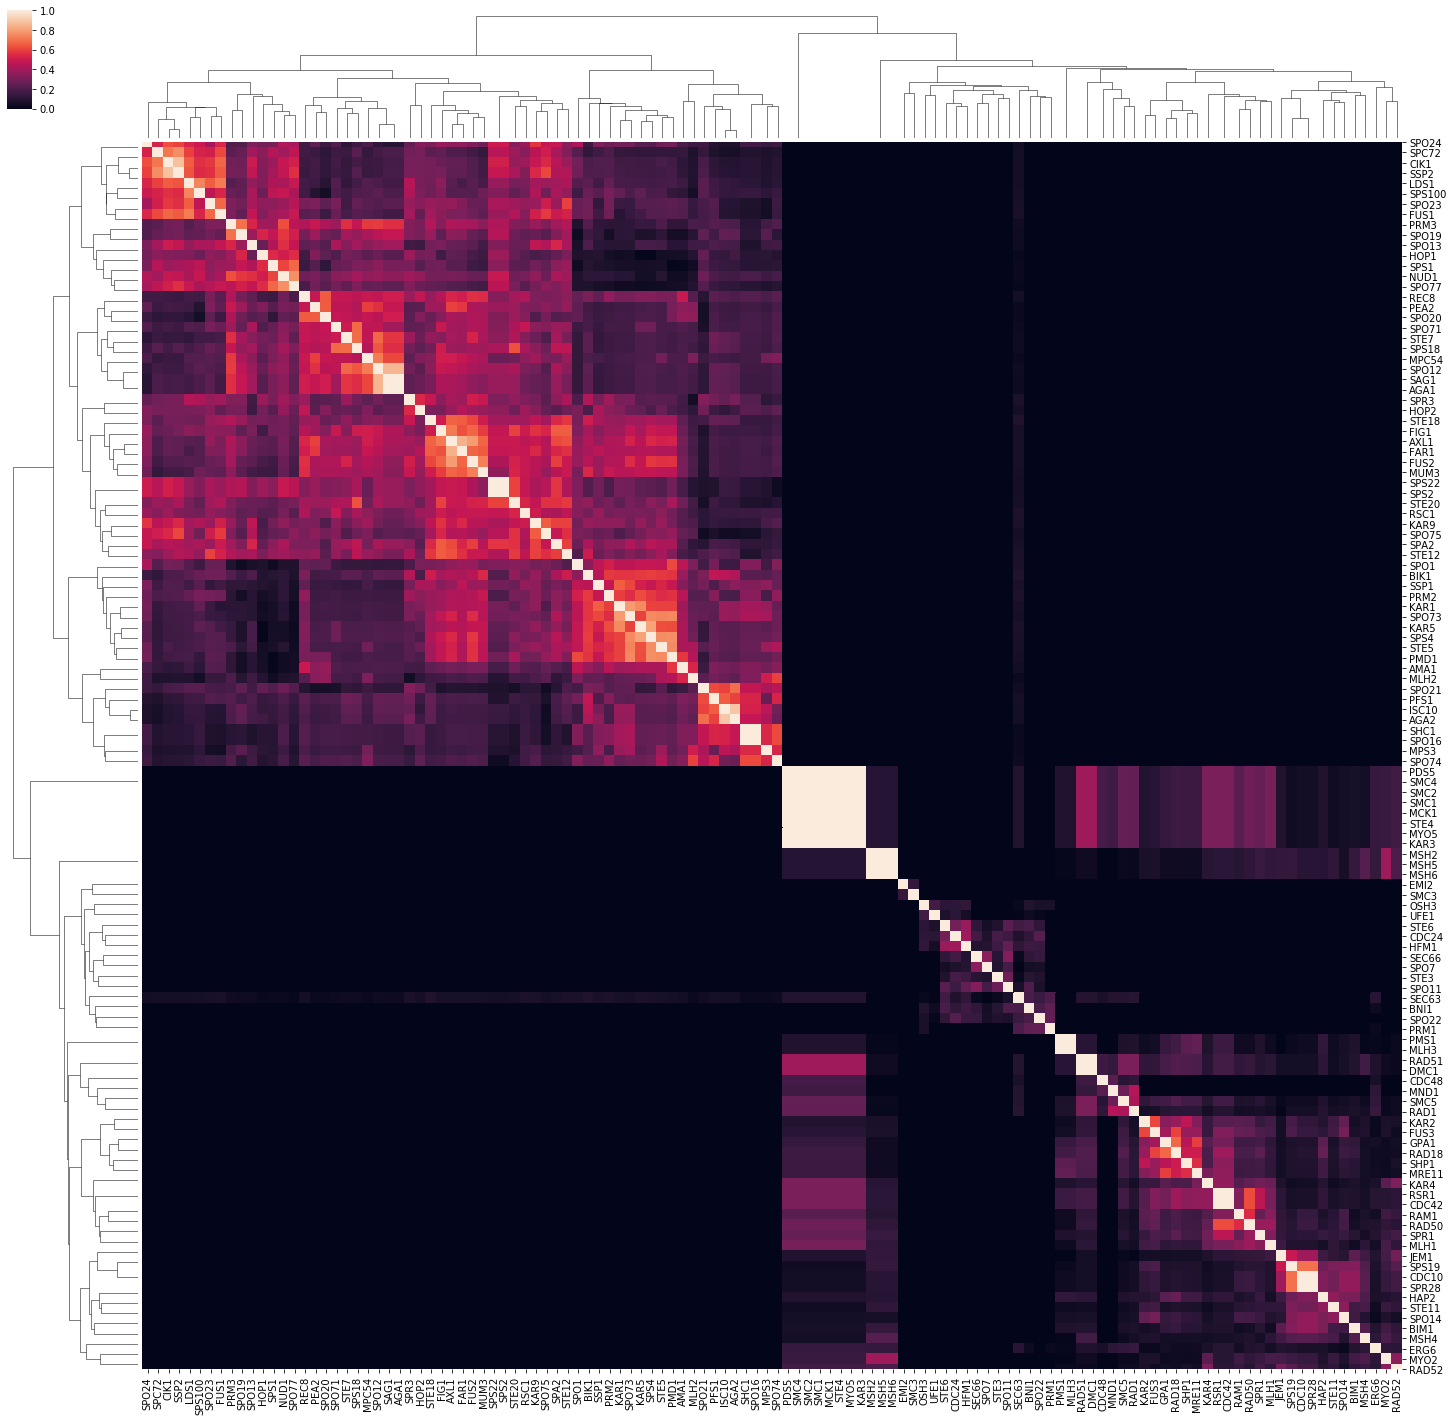

In [56]:
#lets take a look at the clustering of our queries to see if some are coevolving and we can already notice some organisation
jkern = [ [ h1.jaccard(h2) if i<j else 0 for j,h2 in enumerate(hogdf.hashsig) ] for i,h1 in enumerate(hogdf.hashsig)]
jkern = np.asarray(jkern)
jkern+=jkern.T
np.fill_diagonal(jkern , 1 )
g = sns.clustermap( jkern , xticklabels= hogdf['3'] , yticklabels= hogdf['3'] , figsize = (25,25) )

In [57]:
#now lets fill in our network with some putative interactors
res = { h: p.hog_query( hog_id=str(h) , k = 20 ) for h in hogdf.HOG}
Hogs = [ h for results in res.values() for h in results ] + list(res.keys())

In [58]:
profiles = profiles = p.pull_hashes( set(Hogs) )
profiles = { h: {'hashsig': profiles[h] , 'name': names[h]  } if h in names else {'hashsig': profiles[h] , 'name': ''  }   for h in profiles }
profiles = pd.DataFrame.from_dict( profiles , orient='index' )

print(profiles.name.unique())
print(len(profiles.name.unique()))

print(len(profiles))


['' 'SPO21' 'SPO12' 'PFS1' 'SPO13' 'SPO74' 'SPO19' 'SHC1' 'SPO77' 'PRM3'
 'SPO20' 'SPS18' 'STE7' 'SPO71' 'AGA2' 'PEA2' 'SPS1' 'ISC10' 'MPS3'
 'SPO16' 'NUD1' 'AGA1' 'SAG1' 'MLH2' 'MPC54' 'HOP1' 'SSP1' 'SPS100' 'KAR9'
 'SPO1' 'SPO23' 'SSP2' 'CIK1' 'REC8' 'STE12' 'SPO24' 'FUS1' 'FUS2' 'PRM2'
 'KAR1' 'FAR1' 'STE5' 'MUM3' 'SPC72' 'AMA1' 'SPS4' 'AXL1' 'KAR5' 'RSC1'
 'HOP2' 'STE20' 'PMD1' 'SPR3' 'SPO75' 'STE18' 'FIG1' 'BIK1' 'SPS2' 'SPS22'
 'SPO73' 'SPA2' 'LDS1' 'SPO7' 'STE3' 'SEC66' 'SPO11' 'HFM1' 'STE6' 'UFE1'
 'CDC24' 'OSH3' 'BNI1' 'PRM1' 'SPO22' 'JEM1' 'RAD50' 'FUS3' 'STE11' 'MYO2'
 'SPO14' 'MSH4' 'CDC10' 'SPR28' 'SPS19' 'RAD52' 'SPR1' 'MLH1' 'KAR2'
 'MSH6' 'MSH5' 'MSH2' 'RAM1' 'HAP2' 'MRE11' 'KAR4' 'RAD18' 'BIM1' 'SHP1'
 'GPA1' 'CDC42' 'RSR1' 'MLH3' 'PMS1' 'RAD1' 'SMC5' 'RAD51' 'DMC1' 'CDC48'
 'ERG6' 'MND1' 'SEC63' 'PDS5' 'STE4' 'SMC2' 'MCK1' 'SMC1' 'MYO5' 'SMC4'
 'KAR3' 'EMI2' 'SMC3']
121
2065


In [59]:
#lets calculate a new jaccard kernel for all of our search results and queries 
#again we can divide our results into clusters and try to see if each has a functional signature using GO enrichment
jkern = [ [ h1.jaccard(h2) if i<j else 0 for j,h2 in enumerate(profiles.hashsig) ] for i,h1 in enumerate(profiles.hashsig)]
jkern = np.asarray(jkern)
jkern+=jkern.T
np.fill_diagonal(jkern , 1 )



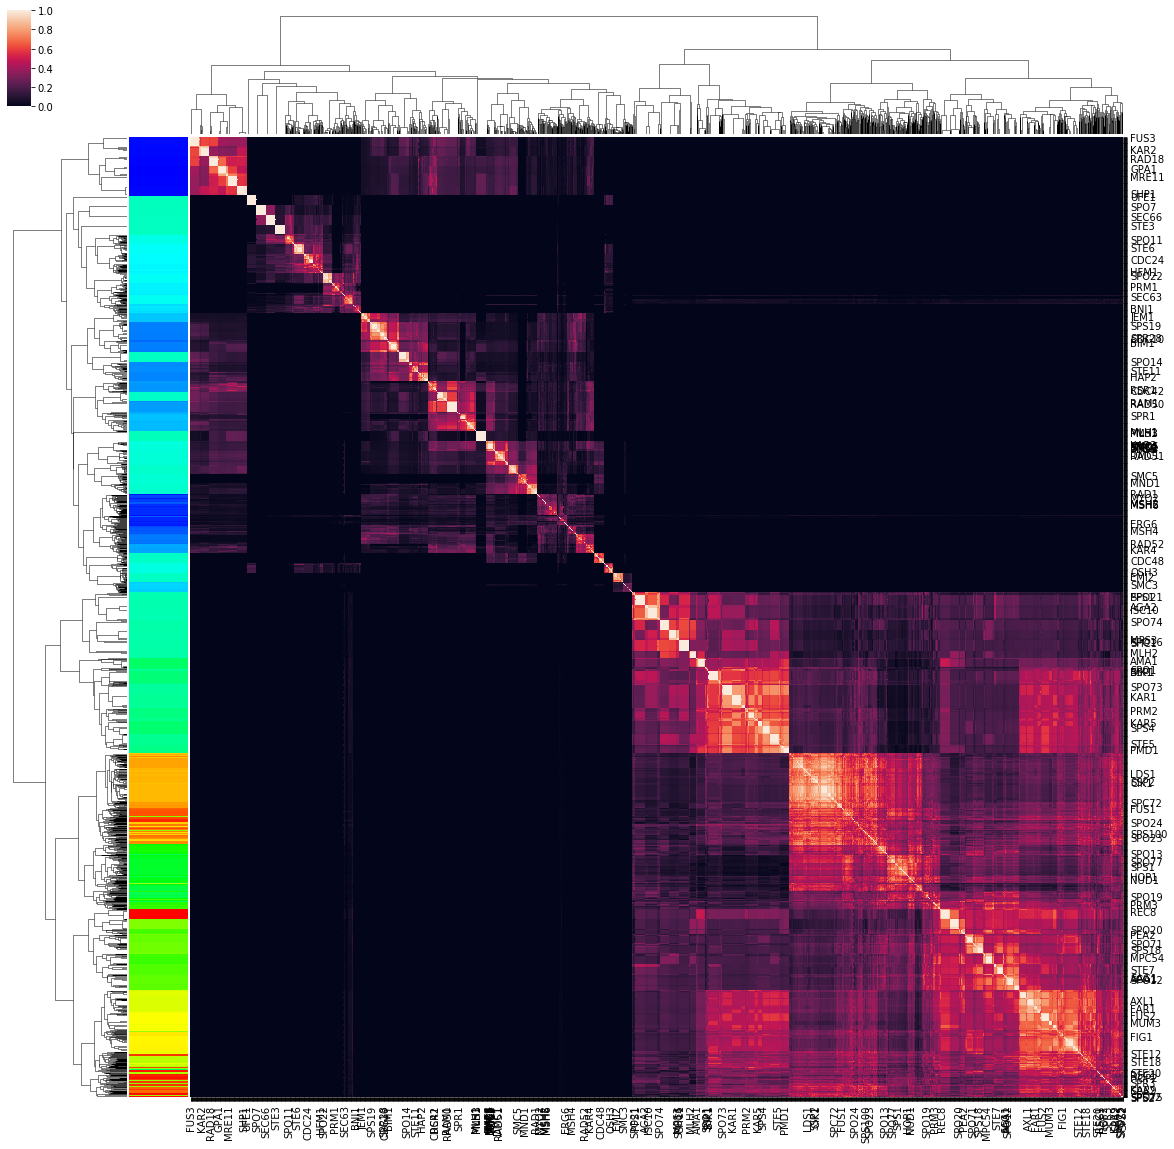

In [60]:
z = scipy.cluster.hierarchy.linkage(jkern, method='single', metric='euclidean')
clusters = scipy.cluster.hierarchy.fcluster(z, t=0.995, criterion='distance')
colors = [ c.hex_l for c in red.range_to( blue , len(set(clusters)) ) ]
colordict2 = dict( zip( list(set(clusters)) , list(colors)))
rowcolors = [ colordict2[c] for c in clusters]
g = sns.clustermap( jkern , xticklabels= profiles.name , yticklabels= profiles.name , figsize = (20,20) , row_colors=rowcolors )
plt.show()

In [68]:
#and here we perform our enrichment of each cluster with a query in it
goares = {}

for c in np.unique(clusters):
    sub = profiles.iloc[ np.where( clusters == c ) ]
    #if our cluster contains a query it makes sense to see if we found some interactors related to it
    if len(sub.name.unique()) >1 : 
        print(sub.name.unique())
        
        queries  = set(sub[ sub.index.map(lambda x : 'HOG' in x )].index )
        #remove the query from search results
        searchfams = [str(hogid2fam(h)) for h in queries ]
        searchres = sub[ sub.index.map(lambda x : 'HOG' not in x )]
        searchres  = searchres[~searchres.index.isin(searchfams)]
        #run a go enrichment study on the cluster
        goares[c] = goa.run_GOEA_onresults( searchres.index.map( hogid2fam ) , p.db_obj, study)
        namestr = ''.join([ n+'_' for n in sub.name if len(n)>0 ])
        #output the results
        goea_results_sig = [r for r in goares[c][0] if r.p_fdr_bh < 0.1]
        study.wr_txt(namestr + "_reprocluster_enrich.txt", goea_results_sig)
        print(len(goea_results_sig))

['' 'REC8']
{'HOG:0218461'}
['218461']
                                                  hashsig name
218313  <datasketch.weighted_minhash.WeightedMinHash o...     
218786  <datasketch.weighted_minhash.WeightedMinHash o...     
218827  <datasketch.weighted_minhash.WeightedMinHash o...     
219333  <datasketch.weighted_minhash.WeightedMinHash o...     
219380  <datasketch.weighted_minhash.WeightedMinHash o...     
219449  <datasketch.weighted_minhash.WeightedMinHash o...     
219466  <datasketch.weighted_minhash.WeightedMinHash o...     
219492  <datasketch.weighted_minhash.WeightedMinHash o...     
220344  <datasketch.weighted_minhash.WeightedMinHash o...     
220453  <datasketch.weighted_minhash.WeightedMinHash o...     
220487  <datasketch.weighted_minhash.WeightedMinHash o...     
220592  <datasketch.weighted_minhash.WeightedMinHash o...     
220770  <datasketch.weighted_minhash.WeightedMinHash o...     
220938  <datasketch.weighted_minhash.WeightedMinHash o...     
220940  <dataske